**Environmental Data Classification Report**
---

----

**1. Introduction**
--

----

The objective of this project is to classify weather data using machine learning algorithms. The dataset includes multiple features such as temperature, humidity, wind speed, pressure, and weather descriptions collected across various cities. The classification task focuses on predicting whether precipitation occurred based on these features.



**Importing the libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy import stats
from sklearn.preprocessing import StandardScaler

**2. Data Collection**
---

----

The datasets has been found on Kaggle. The datasets utilized in this project include:
- **Humidity**: Hourly humidity readings,
- **Pressure**: Hourly atmospheric pressure data,
- **Temperature**: Temperature measurements over time,
- **Weather Description**: Descriptive weather data,
- **Wind Direction**: Hourly wind direction values,
- **Wind Speed**: Wind speed measurements,
for various cities.

The datasets contain over 45,000 records, ensuring sufficient data points for analysis and classification.

In [2]:
# 1) Load the datasets
doc_2 = pd.read_csv('humidity.csv')
doc_3 = pd.read_csv('pressure.csv')
doc_4 = pd.read_csv('temperature.csv')
doc_5 = pd.read_csv('weather_description.csv')
doc_6 = pd.read_csv('wind_direction.csv')
doc_7 = pd.read_csv('wind_speed.csv')

**3. Data Preprocessing and Cleaning**
--

----

Several preprocessing steps were performed to prepare the data for analysis:

**3.1. Handling Missing Values**:
   - Numerical columns were filled with their mean values.
   - Textual columns were forward-filled to retain temporal consistency.

In [3]:
# 2) Filling the empty values with the mean values
numeric_columns = doc_2.select_dtypes(include=['number']).columns

doc_2[numeric_columns] = doc_2[numeric_columns].fillna(doc_2[numeric_columns].mean())
doc_3[numeric_columns] = doc_3[numeric_columns].fillna(doc_3[numeric_columns].mean())
doc_4[numeric_columns] = doc_4[numeric_columns].fillna(doc_4[numeric_columns].mean())
doc_6[numeric_columns] = doc_6[numeric_columns].fillna(doc_6[numeric_columns].mean())
doc_7[numeric_columns] = doc_7[numeric_columns].fillna(doc_7[numeric_columns].mean())

doc_5.fillna(method='ffill', inplace=True)

/var/folders/lm/3vlk3_nd4cg0rx_1zvmg3swm0000gn/T/ipykernel_1517/4025622627.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  doc_5.fillna(method='ffill', inplace=True)


**3.2. Data Reshaping**:
   - Each dataset was transformed into a long format using the `melt` function, with `datetime` and `City` as identifiers.

In [4]:
# 3) Melting the datas
def melt_data(file_name, value_name):
    data = pd.read_csv(file_name)
    melted = pd.melt(data, id_vars=['datetime'], var_name='City', value_name=value_name)
    return melted

humidity = melt_data('humidity.csv', 'Humidity')
pressure = melt_data('pressure.csv', 'Pressure')
temperature = melt_data('temperature.csv', 'Temperature')
weather_description = melt_data('weather_description.csv', 'Weather_Description')
wind_direction = melt_data('wind_direction.csv', 'Wind_Direction')
wind_speed = melt_data('wind_speed.csv', 'Wind_Speed')


- **3.3. Combining Datasets**:
   - All datasets were merged on the `datetime` and `City` columns to form a single comprehensive dataset.

In [5]:
# 4) Combining the datasets
combined_data = (
    humidity
    .merge(pressure, on=['datetime', 'City'], how='inner')
    .merge(temperature, on=['datetime', 'City'], how='inner')
    .merge(weather_description, on=['datetime', 'City'], how='inner')
    .merge(wind_direction, on=['datetime', 'City'], how='inner')
    .merge(wind_speed, on=['datetime', 'City'], how='inner')
)

- **3.4. Outlier Removal**:
   - A z-score threshold of 3 was applied to numerical columns (e.g., humidity, pressure, temperature, wind speed) to remove outliers.
3.5. **Feature Scaling**:
   - Standard scaling was applied to ensure all numerical features had a mean of 0 and a standard deviation of 1.

In [6]:
# 5) Dropping the missing values
cleaned_data = combined_data.dropna()

# Removing Outliers
def remove_outliers(df, columns, threshold=3):
    df_clean = df.copy()
    for col in columns:
        z_scores = stats.zscore(df_clean[col])
        df_clean = df_clean[(abs(z_scores) < threshold)]
    return df_clean

numeric_features = ['Humidity', 'Pressure', 'Temperature', 'Wind_Speed']
cleaned_data = remove_outliers(cleaned_data, numeric_features)

# Scaling the features
scaler = StandardScaler()
cleaned_data[numeric_features] = scaler.fit_transform(cleaned_data[numeric_features])

# Filtering the time to make the dataset smaller
cleaned_data['datetime'] = pd.to_datetime(cleaned_data['datetime'])
filtered_data = cleaned_data[
    (cleaned_data['datetime'] >= '2012-10-01') &
    (cleaned_data['datetime'] <= '2017-11-29')
].copy()

filtered_data = filtered_data[filtered_data['City'] == 'Jerusalem'].copy()

**4. Feature Engineering**
--

----

Several new features were created to enhance the dataset's predictive capabilities:

- **Temporal Features**:
  - Extracted year, month, day, hour, day of the week, and weekend indicators from the `datetime` column.

- **Season and Day/Night Indicators**:
  - Derived the season (e.g., Winter, Spring) and day/night status based on temporal rules.


In [7]:
# Extracting the season feature from the dates
def get_season(month, day):
    if (month == 12 and day >= 21) or (month <= 3 and day <= 20):
        return 'Winter'
    elif (month == 3 and day >= 21) or (month <= 6 and day <= 20):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 9 and day <= 22):
        return 'Summer'
    else:
        return 'Autumn'

filtered_data['Year'] = filtered_data['datetime'].dt.year
filtered_data['Month'] = filtered_data['datetime'].dt.month
filtered_data['Day'] = filtered_data['datetime'].dt.day
filtered_data['Hour'] = filtered_data['datetime'].dt.hour
filtered_data['Day_of_Week'] = filtered_data['datetime'].dt.dayofweek
filtered_data['Is_Weekend'] = filtered_data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
filtered_data['Season'] = filtered_data.apply(lambda x: get_season(x['Month'], x['Day']), axis=1)
filtered_data['Day_Night'] = filtered_data['Hour'].apply(lambda x: 'Day' if 6 <= x < 20 else 'Night')

season_dummies = pd.get_dummies(filtered_data['Season'], prefix='Season', drop_first=True)
daynight_dummies = pd.get_dummies(filtered_data['Day_Night'], prefix='DN', drop_first=True)
filtered_data = pd.concat([filtered_data, season_dummies, daynight_dummies], axis=1)

- **One-Hot Encoding**:
  - Encoded categorical features (e.g., City, Season, Day/Night) into binary indicators for model compatibility.

- **Target Variable Creation**:
  - Generated the `Is_Precip` binary target variable by analyzing keywords in the `Weather_Description` column.

In [8]:
# Adding the rain label
def check_precip(description):
    desc = str(description).lower()
    precip_keywords = ['rain', 'snow', 'drizzle', 'shower', 'storm', 'hail', 'sleet', 'thunderstorm']
    for kw in precip_keywords:
        if kw in desc:
            return 1
    return 0

filtered_data['Is_Precip'] = filtered_data['Weather_Description'].apply(check_precip)

columns_to_drop = ['datetime', 'City', 'Weather_Description', 'Season', 'Day_Night']
existing_columns_to_drop = [col for col in columns_to_drop if col in filtered_data.columns]
X = filtered_data.drop(existing_columns_to_drop, axis=1)
y = filtered_data['Is_Precip']
if 'Is_Precip' in X.columns:
    X = X.drop('Is_Precip', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**5. Comments And Visualization On The Data**
--

----

**5.1 Distribution of the features**

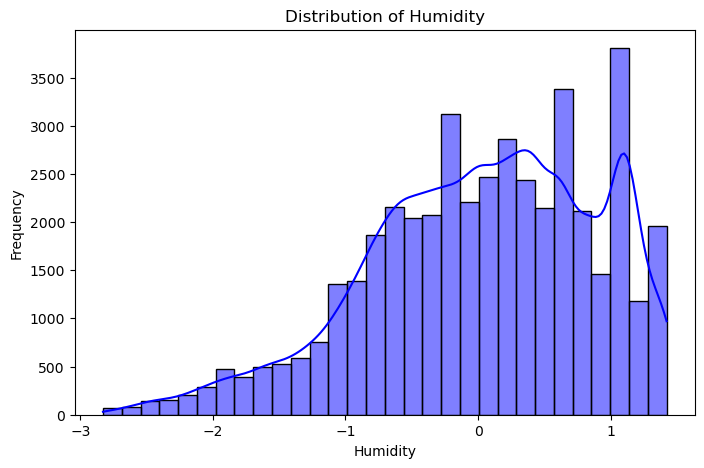

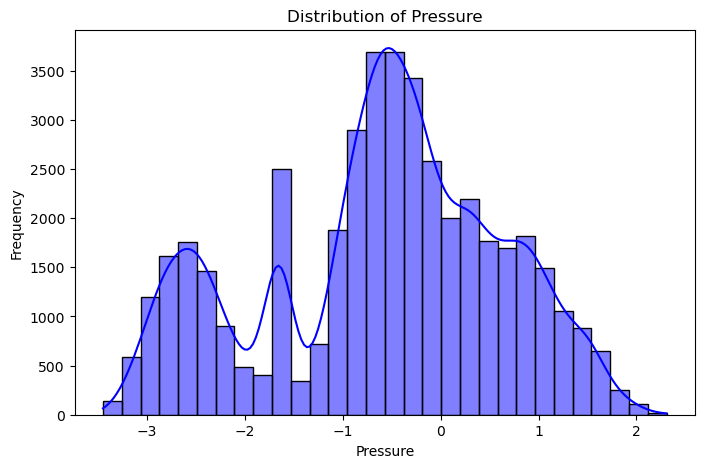

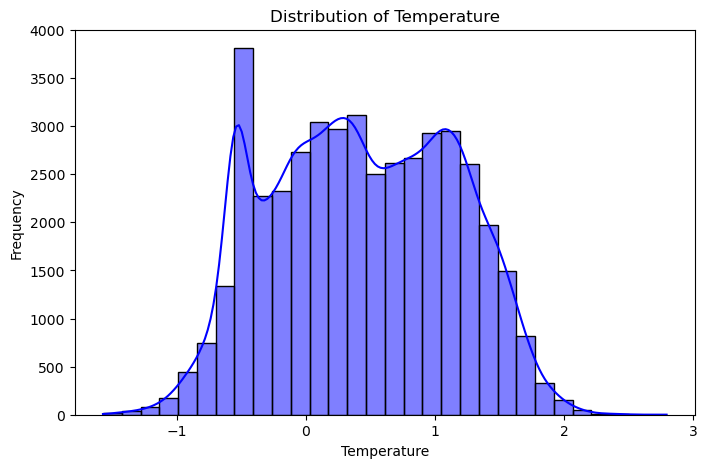

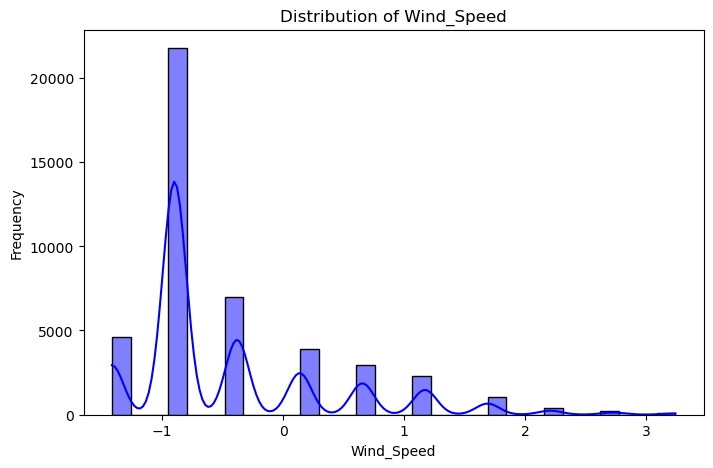

In [9]:
for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_data[feature], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

As can be seen from the result graphs, 

**5.2 Relation Of The Categorical Features With The Target**

- **5.2.1 Season**

In [10]:
# "Is_Weekend" ve "Is_Precip" sütunlarını kategorik/string'e çeviriyoruz
filtered_data['Is_Weekend'] = filtered_data['Is_Weekend'].astype(str)
filtered_data['Is_Precip'] = filtered_data['Is_Precip'].astype(str)



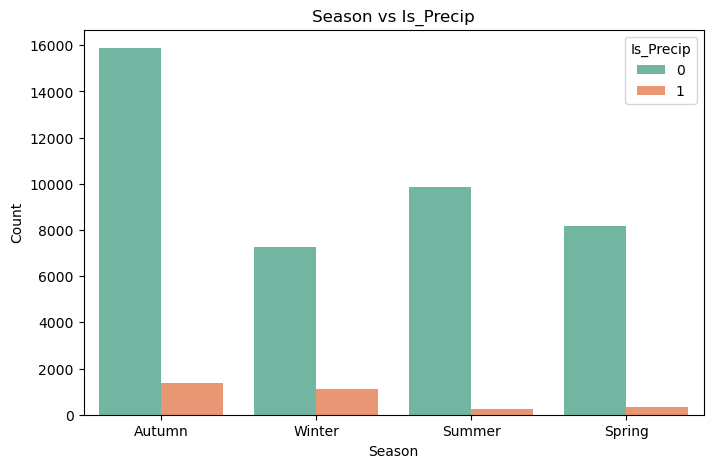

In [11]:
#Season relation
plt.figure(figsize=(8, 5))
sns.countplot(x='Season', hue='Is_Precip', data=filtered_data, palette='Set2')
plt.title(f"{'Season'} vs Is_Precip")
plt.xlabel('Season')
plt.ylabel("Count")
plt.legend(title="Is_Precip", loc="upper right")
plt.show()

1. *Season vs Is_Precip:*
   - *Observation:* 
     - Autumn has the most rainy days compared to other seasons.
     - Summer and Spring have very few rainy days.
     - Winter has some rainy days, but mostly dry.

   - *Inference:* 
     - Rain is most common in Autumn and Winter. Summer and Spring are mostly dry.


- **5.2.2 Day-Night**

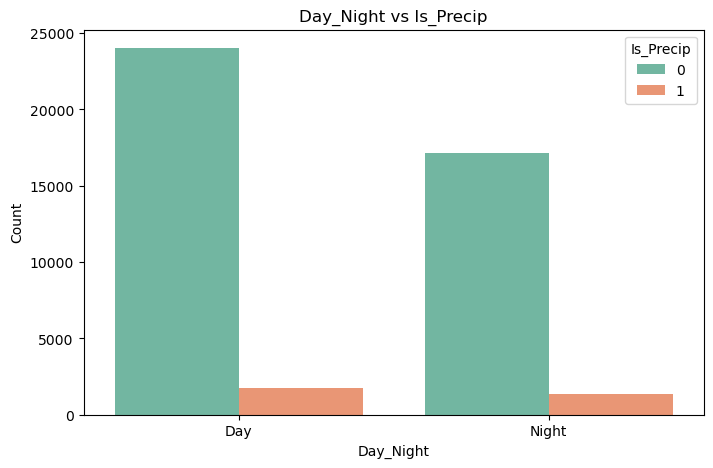

In [12]:
#Day-Night relation
plt.figure(figsize=(8, 5))
sns.countplot(x='Day_Night', hue='Is_Precip', data=filtered_data, palette='Set2')
plt.title(f"{'Day_Night'} vs Is_Precip")
plt.xlabel('Day_Night')
plt.ylabel("Count")
plt.legend(title="Is_Precip", loc="upper right")
plt.show()

2. *Day_Night vs Is_Precip:*
   - *Observation:* 
     - Dry days are more common during the day than at night.
     - Rainy days are similar during both day and night.

   - *Inference:* 
     - Rain doesn’t depend much on whether it’s day or night.

- **5.2.3 Is Weekend**

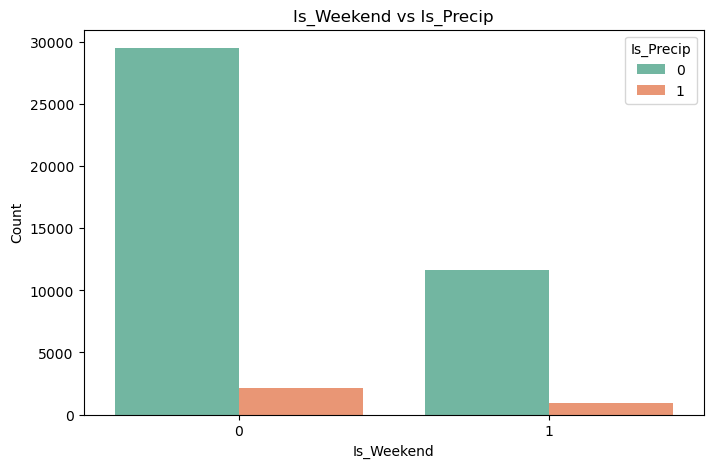

In [13]:
#Day-Night relation
plt.figure(figsize=(8, 5))
sns.countplot(x='Is_Weekend', hue='Is_Precip', data=filtered_data, palette='Set2')
plt.title(f"{'Is_Weekend'} vs Is_Precip")
plt.xlabel('Is_Weekend')
plt.ylabel("Count")
plt.legend(title="Is_Precip", loc="upper right")
plt.show()

3. *Is_Weekend vs Is_Precip:*
   - *Observation:* 
     - Dry days are more common on weekdays than weekends.
     - Rainy days are rare on both weekdays and weekends.

   - *Inference:* 
     - Rain is not affected much by weekdays or weekends.


### Overall Summary

- *Seasons*: Autumn and Winter are rainier, Summer and Spring are mostly dry.
- *Day/Night*: No big difference in rain.
- *Weekdays/Weekends*: Rain is evenly distributed. Dry days are slightly 

**5.3 Correlation Matrix**

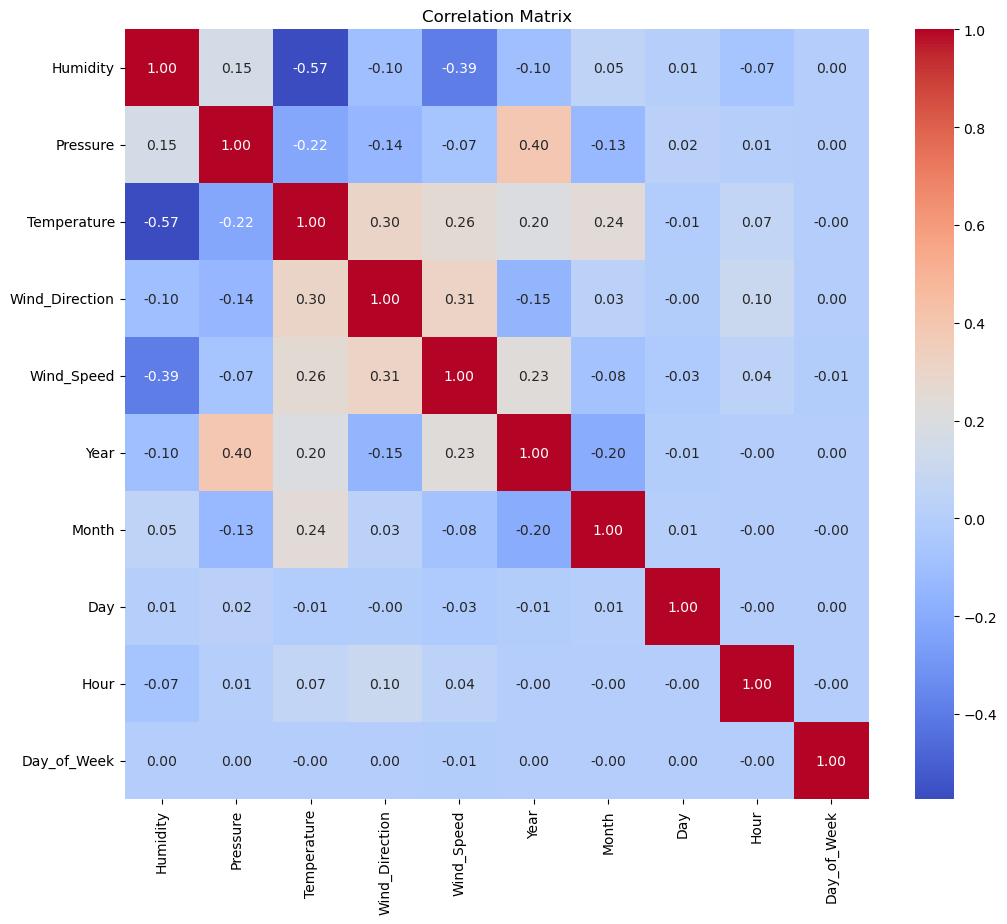

In [14]:
numeric_data = filtered_data.select_dtypes(include=[np.number])  # Sadece sayısal sütunları seç
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Matrix yorum

**6. Predictive Modeling**
--

----

Several classification algorithms were employed:

**6.1. Algorithms Used**:
   - K-Nearest Neighbors (KNN)
   - Logistic Regression
   - Random Forest
   - Gradient Boosting
   - Support Vector Machine (SVM)
   - Neural Network (MLP)
   - XGBoost, LightGBM, and CatBoost

In [15]:
#Creating and evaluating the models 
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=3000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "Neural Network (MLP)": MLPClassifier(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

**6.2. Training and Testing Splitting**:
   - The data was split into training (80%) and testing (20%) sets, ensuring balanced class distribution using stratification.

**6.3. Parameter Optimization**:
   - Hyperparameter tuning was performed using GridSearchCV for each model.

In [16]:
optimized_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    optimized_models[name] = model

/opt/anaconda3/envs/fni1/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:40:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 2451, number of negative: 32917
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 752
[LightGBM] [Info] Number of data points in the train set: 35368, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.069300 -> initscore=-2.597493
[LightGBM] [Info] Start training from score -2.597493


**7. Comparing Model Performances**
--

----

**7.1 Accuracy Comparison**

KNN Test Accuracy: 0.94
Logistic Regression Test Accuracy: 0.94
Random Forest Test Accuracy: 0.98
Gradient Boosting Test Accuracy: 0.95
SVM Test Accuracy: 0.93
Neural Network (MLP) Test Accuracy: 0.94
XGBoost Test Accuracy: 0.98
LightGBM Test Accuracy: 0.97
CatBoost Test Accuracy: 0.98


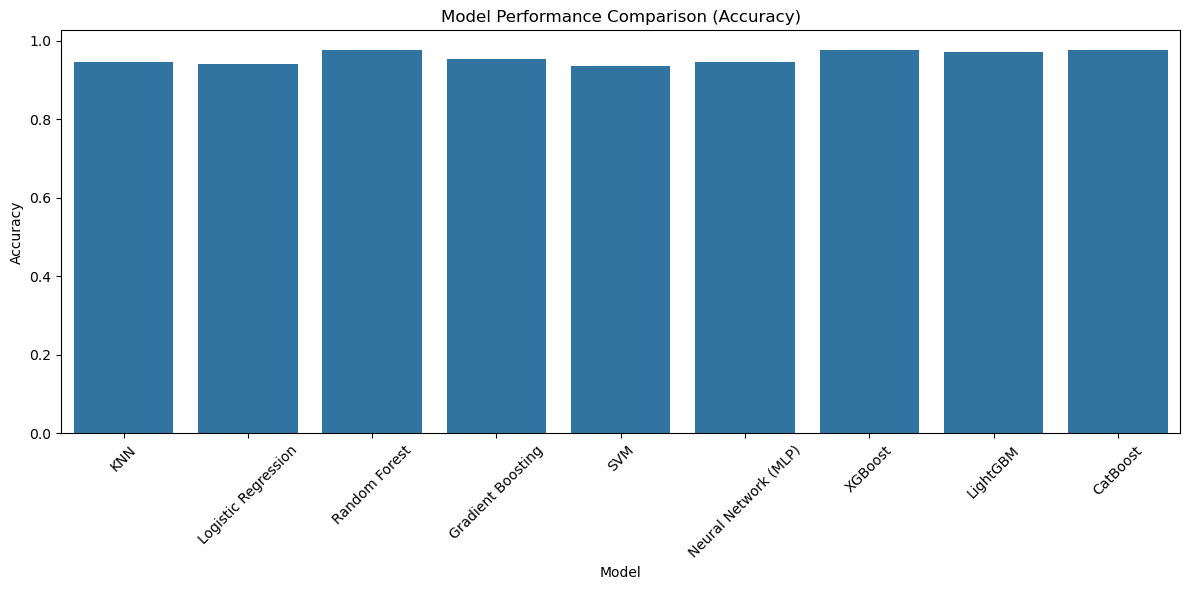

In [17]:
model_scores = {}
for name, model in optimized_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_scores[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy:.2f}")

plt.figure(figsize=(12, 6))
sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()))
plt.title("Model Performance Comparison (Accuracy)")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Model Performance Comparison (Accuracy)

- **Observation:**
  - The chart compares the accuracy of multiple machine learning models.
  - All models have high accuracy, with only slight differences.
  - Random Forest, Gradient Boosting, XGBoost, LightGBM, and CatBoost perform slightly better compared to others.

- **Key Points:**
  - **KNN and Logistic Regression:** These models perform well but are slightly behind the boosting algorithms.
  - **Boosting Models (XGBoost, LightGBM, CatBoost):** These models consistently show top performance with very high accuracy.
  - **Neural Network (MLP):** Performs comparably to the boosting algorithms.
  - **SVM:** Delivers strong accuracy but is slightly lower than boosting models.

- **Conclusion:**
  - Boosting models (XGBoost, LightGBM, CatBoost) and Neural Networks (MLP) are highly effective for achieving high accuracy.
  - All models show reliable performance, but specific models like Random Forest and Gradient Boosting might be preferred for tasks requiring the highest accuracy.


**7.2 Confusion Matrix Results**

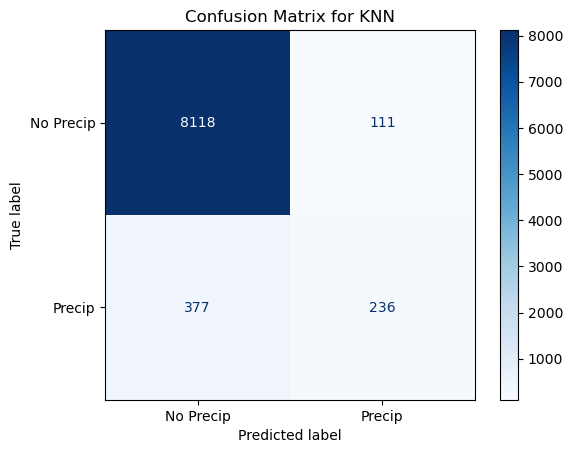

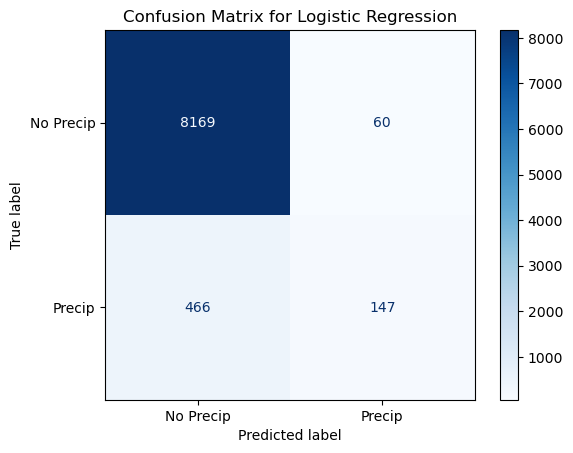

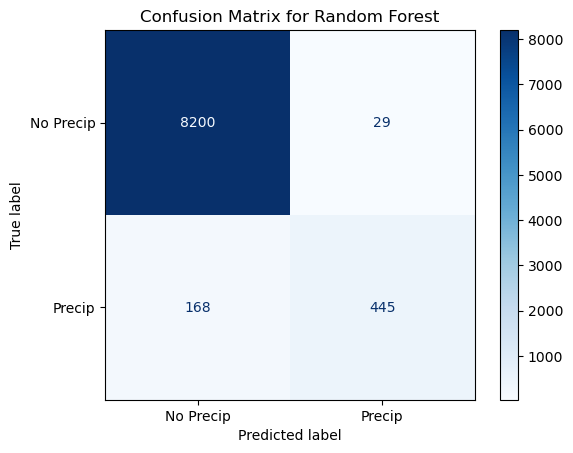

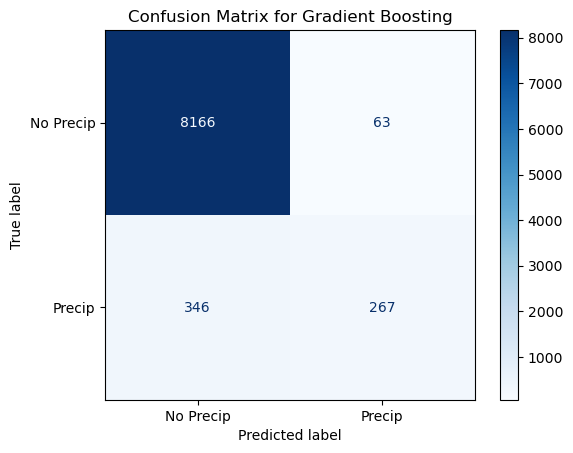

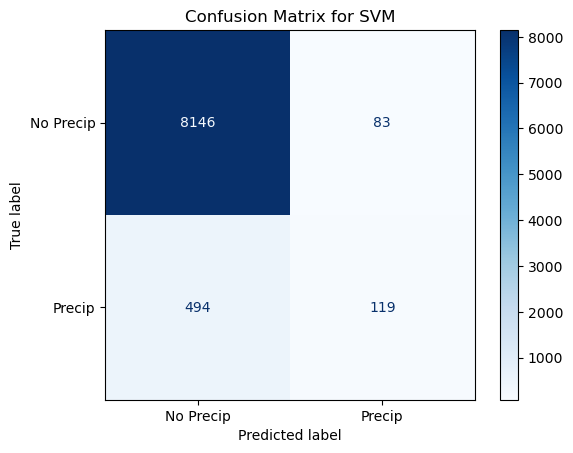

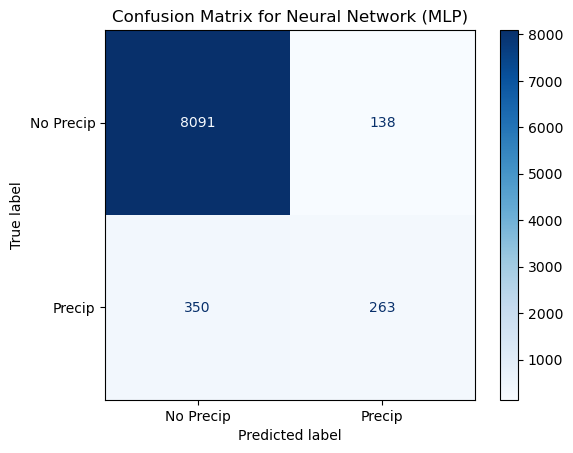

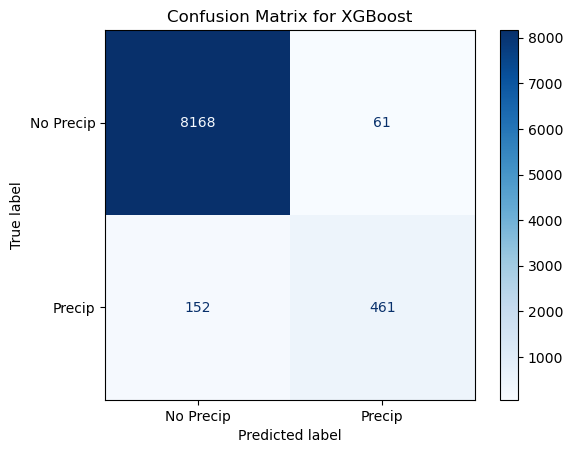

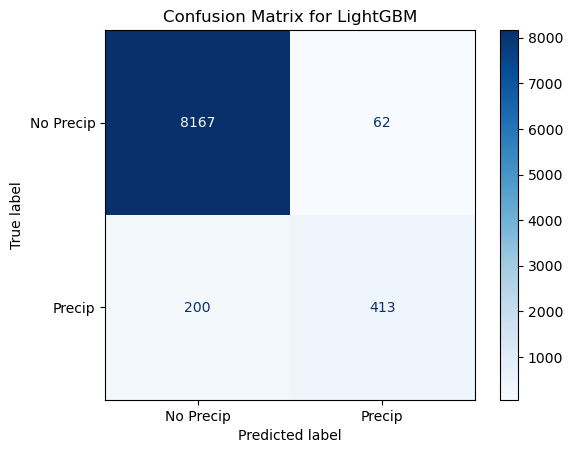

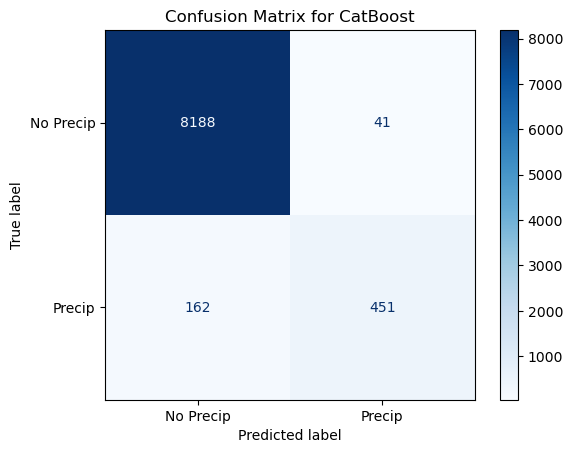

In [18]:
for name, model in optimized_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Precip", "Precip"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

Matrixler yorum

**7.3 Training And Test Results Comparison**

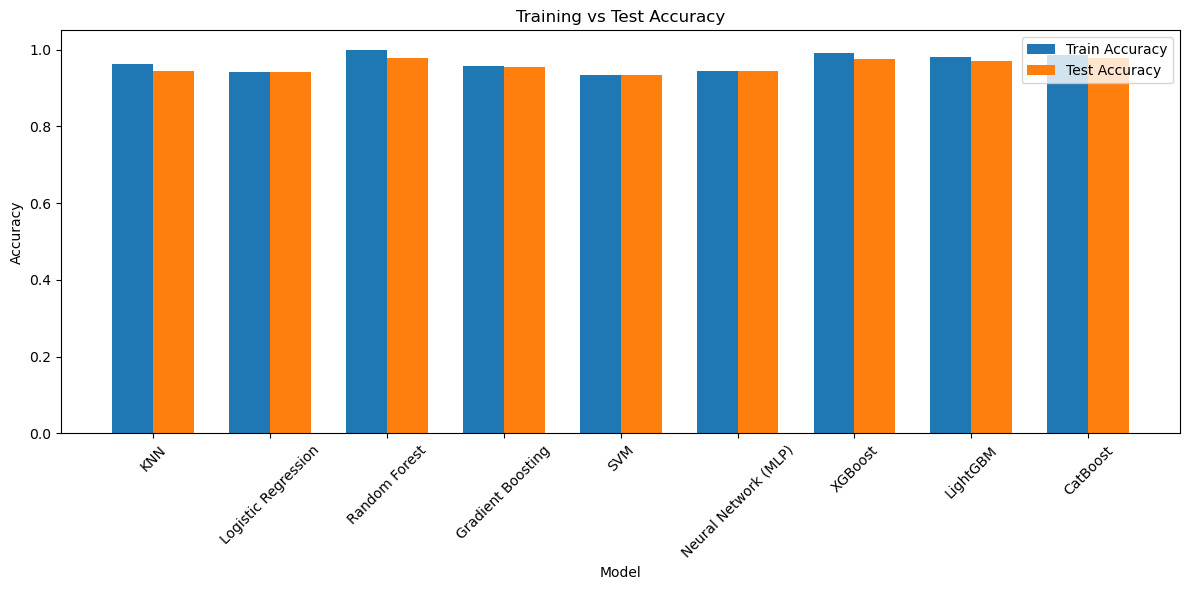

In [19]:
train_accuracies = []
test_accuracies = []
for name, model in optimized_models.items():
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

models = list(optimized_models.keys())

plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35
plt.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy')
plt.xticks(x, models, rotation=45)
plt.title("Training vs Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.legend()
plt.tight_layout()
plt.show()

- As can be seen from the graphs, for every model the training and test accuracies are mostly the same, by looking at this we can deduct that there is no overfitting
- The training accuracies are mostly higher than the testing accuracy (as stated before the difference is not big for any model) which is an expected outcome.

**PREPARED BY FURKAN NECATİ İNAN AND EGEMEN KOZANLI**
--

**Dataset Link:** https://drive.google.com/drive/folders/1VwsN-BdE_llls3Txh0WuB7kKkMxPXfsd?usp=sharing